In [1]:
import random
import os
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

In [158]:
CFG = {
    'TRAIN_WINDOW_SIZE':90,    'PREDICT_SIZE':40,     'EPOCHS':100,    'LEARNING_RATE':1e-4,    'BATCH_SIZE':256,    'SEED':41, 
    'SPLIT_RATE':0.8, 
    'MIN_DELTA':0.001 , 
    'PATIENCE':20  }

In [159]:
class Configs:
    def __init__(self):
        self.seq_len = CFG['TRAIN_WINDOW_SIZE']
        self.pred_len = 40
        self.enc_in = 8 # 가격탄력성 없음 6 
        self.d_model = 32
        self.dropout = 0.2
        self.rnn_type = 'gru'
        self.dec_way = 'pmf'
        self.seg_len = 2
        self.channel_id = True
        self.revin = False

configs = Configs()

In [160]:
samsung =pd.read_csv('../data/삼성전자.csv')[['Date','Close','Volume']]
extrainfo= pd.read_csv('../data/extra_info.csv')
extrainfo = extrainfo.iloc[1:, :]
extrainfo = extrainfo[['날짜','개인','외국인','기관계','기타법인']].rename(columns={'날짜':'Date', '개인':'individ', '외국인':'foreign','기관계':'institute', '기타법인':'extras'})
extrainfo = extrainfo[ ::-1 ].reset_index(drop=True)
extrainfo['Date'] = pd.to_datetime(extrainfo['Date'],format='%y.%m.%d' )
samsung['Date']  =pd.to_datetime(samsung['Date'])

data  = samsung.merge(extrainfo, on='Date', how = 'left')
data[['individ', 'foreign', 'institute', 'extras']] =data[['individ', 'foreign', 'institute', 'extras']].astype(float)
# data = data.set_index('Date').transpose() 
data  = data[['Volume','individ','foreign','institute','extras','Close']]
train = data.iloc[ :-(CFG['PREDICT_SIZE']), :]
vaild = data.iloc[-(CFG['PREDICT_SIZE']): , : ]
# train = train.T 


In [161]:
# 가격 변화율 계산
train['Price_Change_Rate'] = train['Close'].pct_change() * 100
# 순매수량 변화율 계산
train['Fori_Change_Rate'] = train['foreign'].pct_change() * 100
train['Company_Change_Rate'] = train['institute'].pct_change() * 100
# 가격 탄력성 계산
train['Elasticity_Fori'] = train['Fori_Change_Rate'] / train['Price_Change_Rate']
train['Elasticity_Company'] = train['Company_Change_Rate'] / train['Price_Change_Rate']
train = train.drop(columns=['Price_Change_Rate','Fori_Change_Rate','Company_Change_Rate'])
train = train.fillna(0)
# train = train.T 

# 'Close' 열을 가장 마지막으로 이동
# cols = [col for col in train.columns if col != 'Close'] + ['Close']


# 'inf' 값을 1,000,000으로 변경
train= train.replace(np.inf, 1000000)

# '-inf' 값을 -1,000,000으로 변경
train = train.replace(-np.inf, -1000000)
train = train.T 



/tmp/ipykernel_101608/132015371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price_Change_Rate'] = train['Close'].pct_change() * 100
/tmp/ipykernel_101608/132015371.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Fori_Change_Rate'] = train['foreign'].pct_change() * 100
/tmp/ipykernel_101608/132015371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [162]:
# Class Definitions


class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()

        # 설정값에서 필요한 파라미터를 가져옵니다.
        self.seq_len = configs.seq_len  # 입력 시퀀스 길이
        self.pred_len = configs.pred_len  # 예측할 시퀀스 길이
        self.enc_in = configs.enc_in  # 입력 데이터의 차원 수(채널 수)
        self.d_model = configs.d_model  # 모델의 차원 수
        self.dropout = configs.dropout  # 드롭아웃 비율

        self.rnn_type = configs.rnn_type  # RNN의 유형 (RNN, GRU, LSTM 중 선택)
        self.dec_way = configs.dec_way  # 예측 방식 (rmf: Recurrent Multi-step Forecasting, pmf: Parallel Multi-step Forecasting 중 선택)
        self.seg_len = configs.seg_len  # 세그먼트의 길이
        self.channel_id = configs.channel_id  # 채널 ID 사용 여부
        self.revin = configs.revin  # RevIN 레이어 사용 여부

        assert self.rnn_type in ['rnn', 'gru', 'lstm']
        assert self.dec_way in ['rmf', 'pmf']

        #입력 시퀀스를 세그먼트로 나누어 세그먼트의 개수를 계산합니다.
        self.seg_num_x = self.seq_len//self.seg_len

        # valueEmbedding 레이어: 세그먼트를 d_model 차원의 벡터로 임베딩합니다.
        self.valueEmbedding = nn.Sequential(
            nn.Linear(self.seg_len, self.d_model),
            nn.ReLU()
        )

        if self.rnn_type == "rnn":            self.rnn = nn.RNN(input_size=self.d_model, hidden_size=self.d_model, num_layers=1, bias=True,                              batch_first=True, bidirectional=False)
        elif self.rnn_type == "gru":            self.rnn = nn.GRU(input_size=self.d_model, hidden_size=self.d_model, num_layers=1, bias=True,                              batch_first=True, bidirectional=False)
        elif self.rnn_type == "lstm":            self.rnn = nn.LSTM(input_size=self.d_model, hidden_size=self.d_model, num_layers=1, bias=True,                              batch_first=True, bidirectional=False)

        if self.dec_way == "rmf":
            self.seg_num_y = self.pred_len // self.seg_len
            self.predict = nn.Sequential(   nn.Dropout(self.dropout),     nn.Linear(self.d_model, self.seg_len)            )
            
        elif self.dec_way == "pmf":
            self.seg_num_y = self.pred_len // self.seg_len

            if self.channel_id:
                # seg_num_y 가 28//2 인 14이고 모델 차원이 32이면 14x16의 파라미터 행렬 생성된다. 
                self.pos_emb = nn.Parameter(torch.randn(self.seg_num_y, self.d_model // 2))
                # 채널의개수 x 모델차원//2 의 파라미터 행령 생성된다. 
                self.channel_emb = nn.Parameter(torch.randn(self.enc_in, self.d_model // 2))
            else:
                self.pos_emb = nn.Parameter(torch.randn(self.seg_num_y, self.d_model))

            self.predict = nn.Sequential(
                # 순서대로 처리하게 해주는 역할 
                nn.Dropout(self.dropout),
                nn.Linear(self.d_model, self.seg_len)
            )
        if self.revin:
            self.revinLayer = RevIN(self.enc_in, affine=False, subtract_last=False)


    def forward(self, x):

        # b:batch_size c:channel_size s:seq_len s:seq_len
        # d:d_model w:seg_len n:seg_num_x m:seg_num_y
        batch_size = x.size(0)
        # normalization and permute     b,s,c -> b,c,s
        if self.revin:
            x = self.revinLayer(x, 'norm').permute(0, 2, 1)
        else:
            seq_last = x[:, -1:, :].detach()
            x = (x - seq_last).permute(0, 2, 1) # b,c,s

        # segment and embedding    b,c,s -> bc,n,w -> bc,n,d
        newx = x.reshape(-1, self.seg_num_x, self.seg_len)
        # print(f"newx size : {newx.shape}")
        x = self.valueEmbedding(newx)
        # print(f"after embedding : {x.shape}")
        # print(f"after embedding input: {x}")
        
        # encoding
        if self.rnn_type == "lstm":_, (hn, cn) = self.rnn(x)
        #hidden layer = (1, batchsize*channel num , d_model(hiddensize))
        else: _, hn = self.rnn(x) # bc,n,d  1,bc,d 
        

        # decoding
        if self.dec_way == "rmf":
            y = []
            for i in range(self.seg_num_y):
                yy = self.predict(hn)    # 1,bc,l
                yy = yy.permute(1,0,2)   # bc,1,l
                y.append(yy)
                yy = self.valueEmbedding(yy)
                if self.rnn_type == "lstm":
                    _, (hn, cn) = self.rnn(yy, (hn, cn))
                else:
                    _, hn = self.rnn(yy, hn)
            y = torch.stack(y, dim=1).squeeze(2).reshape(-1, self.enc_in, self.pred_len) # b,c,s
        
        elif self.dec_way == "pmf":
            if self.channel_id:
                # m,d//2 -> 1,m,d//2 -> c,m,d//2
                # c,d//2 -> c,1,d//2 -> c,m,d//2
                # c,m,d -> cm,1,d -> bcm, 1, d
                # print(f"before pos emb : {self.pos_emb.unsqueeze(0).repeat(self.enc_in, 1, 1).shape}")#(1,14,16)
                # print(f"before channel emb : {self.channel_emb.unsqueeze(1).repeat(1, self.seg_num_y, 1).shape}")#(1,14,16)
                pos_emb = torch.cat([
                    #채널의 개수 enc_in만큼 pos_emb를 쌓아올린다
                    self.pos_emb.unsqueeze(0).repeat(self.enc_in, 1, 1),
                    # (enc_in)x(d_model/2) -> (enc_in,1,d_model/2)->  (enc_in,seg_num_y, d_model/2)
                    self.channel_emb.unsqueeze(1).repeat(1, self.seg_num_y, 1)
                ], dim=-1).view(-1, 1, self.d_model).repeat(batch_size,1,1)
                # dim = -1에 대해 cat하니까 (enc_in,seg_num_y,d_model) 로 형태 변경 
                # (enc_in,seg_num_y,d_model)-> (enc_in*seg_num_y,1,d_model)--repeat-->(batch*enc_in*seg_num_y,1,d_model)
                # print(f"pos emb : {pos_emb.shape}")
            else:
                # m,d -> bcm,d -> bcm, 1, d
                pos_emb = self.pos_emb.repeat(batch_size * self.enc_in, 1).unsqueeze(1)

            # pos_emb: m,d -> bcm,d ->  bcm,1,d
            # hn, cn: 1,bc,d -> 1,bc,md -> 1,bcm,d
            if self.rnn_type == "lstm":
                _, (hy, cy) = self.rnn(pos_emb,
                                       (hn.repeat(1, 1, self.seg_num_y).view(1, -1, self.d_model),
                                        cn.repeat(1, 1, self.seg_num_y).view(1, -1, self.d_model)))
            else:
                #hn은 아까 gru or rnn의 hiddenlayer로 전체 입력에 대한 요약된 정보이다. (1, 1024,32)-> (1,1024, 32*14)
                # print(f"hiddenlayer : {hn.shape}")
                # print(f"hiddenlayer stac : {hn.repeat(1, 1, self.seg_num_y).shape}")
                # print(f"hiddenlayer stacked: {hn.repeat(1, 1, self.seg_num_y).view(1, -1, self.d_model).shape}")
                
                # 초기의 hiddenstate를 hn.repeat(1, 1, self.seg_num_y).view(1, -1, self.d_model)으로 정의하여 rnn에 전달하기 
                _, hy = self.rnn(pos_emb, hn.repeat(1, 1, self.seg_num_y).view(1, -1, self.d_model))
            # 1,bcm,d -> 1,bcm,w -> b,c,s
            y = self.predict(hy).view(-1, self.enc_in, self.pred_len)

        # permute and denorm
        if self.revin:
            y = self.revinLayer(y.permute(0, 2, 1), 'denorm')
        else:
            y = y.permute(0, 2, 1) + seq_last

        return y
    
    
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [163]:
# Function to reshape the data into a time series format for each ID
def reshape_data(df):
    time_series_data = []
    for idx, row in df.iterrows():
        sales_data = row[0:].values.astype(float)
        time_series_data.append(sales_data)
    return np.array(time_series_data)

# Modified time_slide_df function to work with the current data format
def time_slide_df(data, window_size, forecast_size):
    data_list = []
    dap_list = []
    # len(data) = 1523 (데이터 전체에 몇 일치의 데이터인지 ), windowsize=72 (72일을 보고나서 28일을 예측하겠다), forecastsize = 28 
    # data_list = 1424x72  의 형태이다, dap_list =1424x 28 의 형태이다 즉, 하나의 제품에 대해서 1424개의 학습 데이터 셋이 만들어 진 것이다. 
    for idx in range(0, len(data) - window_size - forecast_size + 1):
        x = data[idx:idx + window_size].reshape(window_size, 1)
        
        y = data[idx + window_size:idx + window_size + forecast_size]
        data_list.append(x)
        dap_list.append(y)
    # print(f"{len(data_list)} is shape of x and {len(dap_list)} is shape of y , {len(data) }")
    # print(dap_list)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

# Function to create DataLoader for each ID
def create_dataloader(data, window_size, forecast_size, batch_size):
    X, Y = time_slide_df(data, window_size, forecast_size)
    ds = Data(X, Y)
    # print(ds())
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# 특산물의 메타 데이터는 버리고 일별 가격 정보만 갖고오기 
time_series_data = reshape_data(train)
# 데이터 표준화
means = np.mean(time_series_data, axis=1, keepdims=True)
stds = np.std(time_series_data, axis=1, keepdims=True)
standardized_data = (time_series_data - means) / stds
# DataLoader 생성 함수 수정
from torch.utils.data import DataLoader, TensorDataset
def create_dataloader(data, train_window_size, predict_size, batch_size):
    sequences = []
    targets = []
    for i in range(data.shape[1] - train_window_size - predict_size + 1):
        seq = data[:, i:i + train_window_size]
        target = data[:, i + train_window_size:i + train_window_size + predict_size]
        sequences.append(seq)
        targets.append(target)
    sequences = np.stack(sequences)
    targets = np.stack(targets)
    
    dataset = TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# DataLoader 생성
train_dl = create_dataloader(standardized_data, CFG['TRAIN_WINDOW_SIZE'], CFG['PREDICT_SIZE'], CFG['BATCH_SIZE'])
epoch_count = 100
lr = 0.001
min_delta = 0.001
patience = 10

# Model Train 

In [8]:
future_expect=[]
for seed in [42 , 44] :
    seed_everything(seed)
    # 모델 정의
    seg_rnn = Model(configs)
    seg_rnn.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(seg_rnn.parameters(), lr=lr)
    best_loss = float('inf')
    no_improvement_count = 0
    for epoch in range(1, CFG['EPOCHS'] + 1):
        loss_list = []
        seg_rnn.train()
        for batch_idx, (data, target) in enumerate(train_dl):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            data = data.permute(0, 2, 1)
            # 타겟 차원 변경
            target = target.permute(0, 2, 1)
            output = seg_rnn(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        
        # 에폭별 평균 손실 계산 및 출력
        avg_loss = np.mean(loss_list)
        # print(f"Epoch {epoch}/{CFG['EPOCHS']}, 평균 손실: {avg_loss:.6f}")
        
        # 개선 여부 확인
        if avg_loss + CFG['MIN_DELTA'] < best_loss:
            best_loss = avg_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= CFG['PATIENCE']:
                print(f"조기 종료: {epoch} 에폭에서 개선되지 않음")
                break
            
        # 미래 예측
    last_window_data = torch.tensor(standardized_data[:, -CFG['TRAIN_WINDOW_SIZE']:]).unsqueeze(0).float().to(device)
    last_window_data = last_window_data.permute(0,2,1)
    future_prediction = seg_rnn(last_window_data)

    future_prediction = future_prediction.squeeze(0).detach().cpu().numpy()  # shape: (20, 6)

    # 각 컬럼별로 표준편차와 평균을 곱하고 더하여 원래 스케일로 변환
    for i in range(future_prediction.shape[1]):  # 각 컬럼에 대해
        future_prediction[:, i] = future_prediction[:, i] * stds[i] + means[i]
        
    # 결과 저장
    future_expect.append(future_prediction)
    
# 각 시드별 예측 결과의 평균을 구하여 최종 결과로 저장
final_predict = np.mean(future_expect, axis=0)


In [149]:
def eval_model(dmodel,drop,seglen):
    class Configs:
        def __init__(self):
            self.seq_len = CFG['TRAIN_WINDOW_SIZE']
            self.pred_len = 40
            self.enc_in = 8
            self.d_model = dmodel
            self.dropout = drop
            self.rnn_type = 'gru'
            self.dec_way = 'pmf'
            self.seg_len = seglen
            self.channel_id = True
            self.revin = False

    configs = Configs()
    future_expect=[]
    for seed in [42 , 44] :
        seed_everything(seed)
        iTransformer =Model(configs)
        iTransformer.to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(iTransformer.parameters(), lr=lr)
        best_loss = float('inf')
        no_improvement_count = 0
        for epoch in range(1, 125):
            loss_list = []
            iTransformer.train()
            for batch_idx, (data, target) in enumerate(train_dl):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                data = data.permute(0, 2, 1)
                # 타겟 차원 변경
                target = target.permute(0, 2, 1)
                output = iTransformer(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())
            
            # 에폭별 평균 손실 계산 및 출력
            avg_loss = np.mean(loss_list)
            print(f"Epoch {epoch}/{CFG['EPOCHS']}, 평균 손실: {avg_loss:.6f}")
            
            # 개선 여부 확인
            if avg_loss + CFG['MIN_DELTA'] < best_loss:
                best_loss = avg_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= CFG['PATIENCE']:
                    # print(f"조기 종료: {epoch} 에폭에서 개선되지 않음")
                    break
                
            # 미래 예측
        last_window_data = torch.tensor(standardized_data[:, -CFG['TRAIN_WINDOW_SIZE']:]).unsqueeze(0).float().to(device)
        last_window_data = last_window_data.permute(0,2,1)
        future_prediction = iTransformer(last_window_data)
        future_prediction = future_prediction.squeeze(0).detach().cpu().numpy()  # shape: (20, 6)
        for i in range(future_prediction.shape[1]):  # 각 컬럼에 대해
            future_prediction[:, i] = future_prediction[:, i] * stds[i] + means[i]
        future_expect.append(future_prediction)
        
    # 각 시드별 예측 결과의 평균을 구하여 최종 결과로 저장
    final_predict = np.mean(future_expect, axis=0)
    final_predict = final_predict.T
    expect_vals = final_predict[5]
    
    print(dmodel,drop,seglen)
    prediction_numpy = expect_vals
    for_score_close = vaild['Close']
    for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]
    plt.figure(figsize=(9, 4))  # 그래프의 크기 설정
    plt.plot(prediction_numpy, marker='o', linestyle='-', color='b', label='Prediction')
    plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')
    plt.title('Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    res_df =for_score_close_last_10.values.tolist()
    squared_differences = []
    for i in range(40):
        difference = expect_vals[i] - res_df[i]
        squared_difference = difference ** 2
        squared_differences.append(squared_difference)
    # 텐서를 numpy 배열로 변환하여 MSE 계산
    squared_differences = torch.tensor(squared_differences)
    mse = squared_differences.mean().detach().numpy()
    # RMSE 계산
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("*************************************************************************************")
    return final_predict
    
        
# for dmodel in [32,64]:
#     for drop in [0.05, 0.1]:
#         for seglen in [2]:
#             eval_model(dmodel, drop, seglen) 


In [ ]:
# 60 , 32 0.05 2, 2372
# 90 , 32 0.05 2, 1985
# 120,32 0.05 2 , 2139 , 2240
# 150, 32 0.05 2, 2164 , 2105

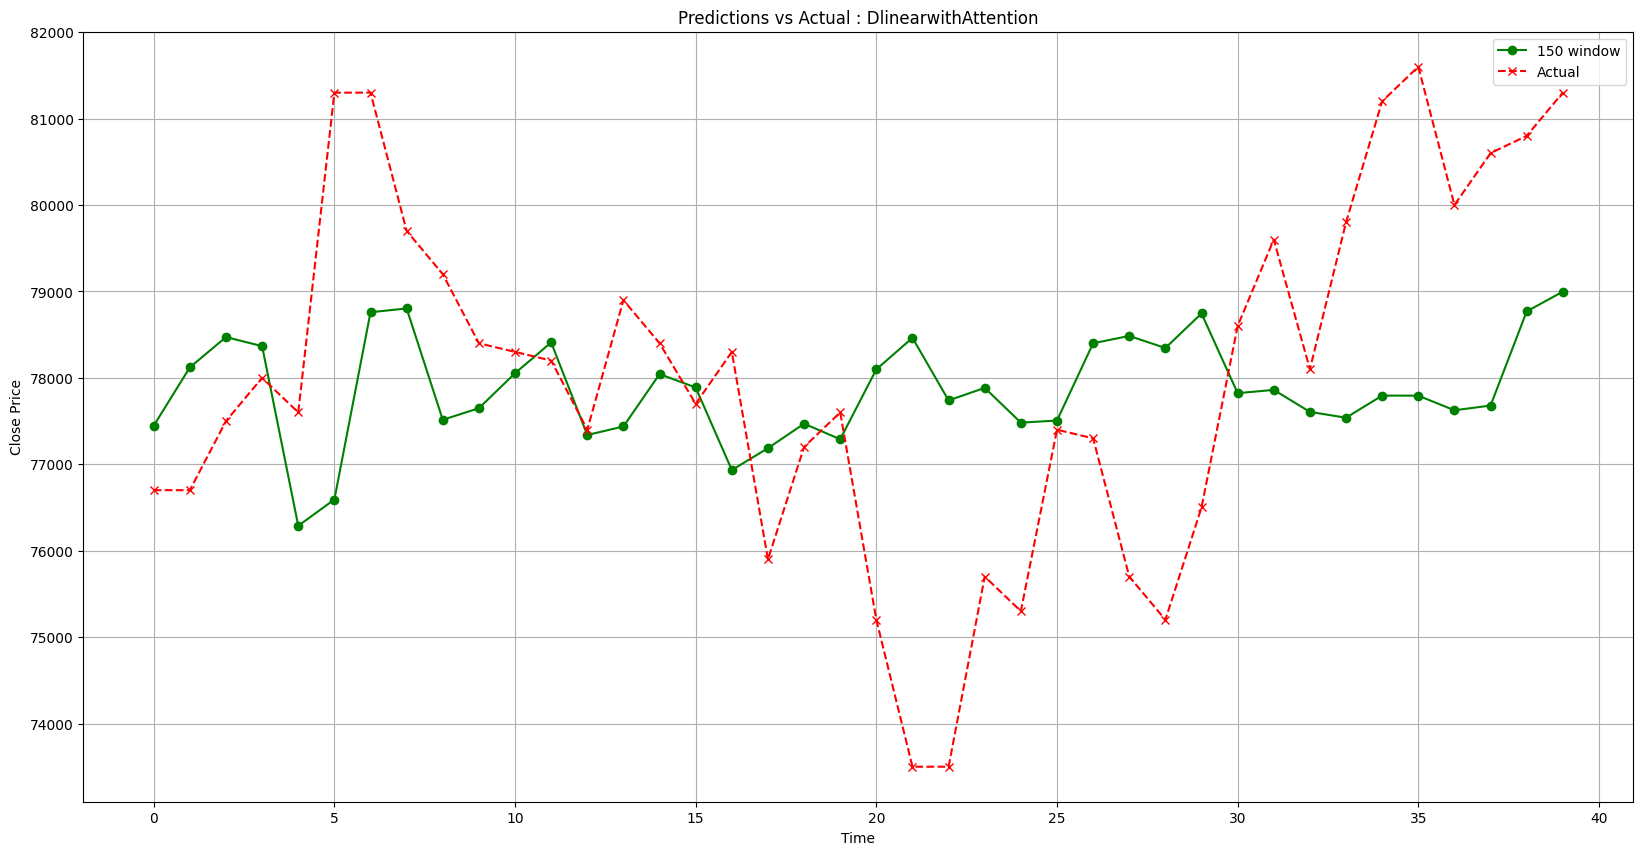

In [69]:
def plot_predictions(window_60, window_90, window_120, window_150, for_score_close, CFG):
    # 실제 값 추출
    for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]
    
    # 시각화
    plt.figure(figsize=(20, 10))  # 그래프의 크기 설정
    
    # 각 예측 값 시각화
    # plt.plot(window_60, marker='o', linestyle='-', color='b', label='60 window')
    # plt.plot(window_90, marker='o', linestyle='-', color='g', label='90 window')
    # plt.plot(window_120, marker='o', linestyle='-', color='b', label='120 window')
    plt.plot(window_150, marker='o', linestyle='-', color='g', label='150 window')
    
    # 실제 값 시각화
    plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')
    
    # 그래프의 제목 및 축 레이블 설정
    plt.title('Predictions vs Actual : DlinearwithAttention')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# 함수 호출 예시
plot_predictions(pred60, pred90, pred120, pred150, vaild['Close'], CFG)


Epoch 1/100, 평균 손실: 1.351749
Epoch 2/100, 평균 손실: 1.134880
Epoch 3/100, 평균 손실: 1.029111
Epoch 4/100, 평균 손실: 0.972794
Epoch 5/100, 평균 손실: 0.914972
Epoch 6/100, 평균 손실: 0.877868
Epoch 7/100, 평균 손실: 0.868970
Epoch 8/100, 평균 손실: 0.847570
Epoch 9/100, 평균 손실: 0.844607
Epoch 10/100, 평균 손실: 0.825991
Epoch 11/100, 평균 손실: 0.828584
Epoch 12/100, 평균 손실: 0.855298
Epoch 13/100, 평균 손실: 0.833849
Epoch 14/100, 평균 손실: 0.820013
Epoch 15/100, 평균 손실: 0.816338
Epoch 16/100, 평균 손실: 0.820212
Epoch 17/100, 평균 손실: 0.811034
Epoch 18/100, 평균 손실: 0.808339
Epoch 19/100, 평균 손실: 0.809648
Epoch 20/100, 평균 손실: 0.810138
Epoch 21/100, 평균 손실: 0.813532
Epoch 22/100, 평균 손실: 0.808157
Epoch 23/100, 평균 손실: 0.822871
Epoch 24/100, 평균 손실: 0.815022
Epoch 25/100, 평균 손실: 0.801477
Epoch 26/100, 평균 손실: 0.797742
Epoch 27/100, 평균 손실: 0.813026
Epoch 28/100, 평균 손실: 0.806277
Epoch 29/100, 평균 손실: 0.797844
Epoch 30/100, 평균 손실: 0.801755
Epoch 31/100, 평균 손실: 0.801159
Epoch 32/100, 평균 손실: 0.798180
Epoch 33/100, 평균 손실: 0.801565
Epoch 34/100, 평균 손실

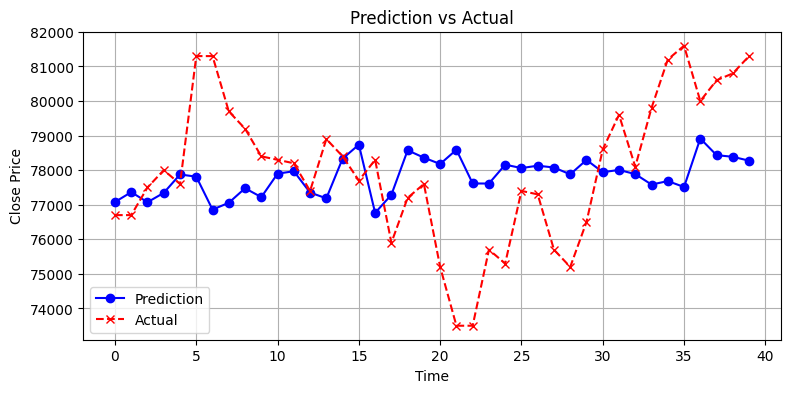

Root Mean Squared Error (RMSE): 2202.6951029805828
*************************************************************************************


In [164]:
# pred60 = eval_model(32,0.05, 2)
pred90 = eval_model(32,0.05, 2)
# pred120= eval_model(32,0.05, 2)
# pred150= eval_model(32,0.05, 2)

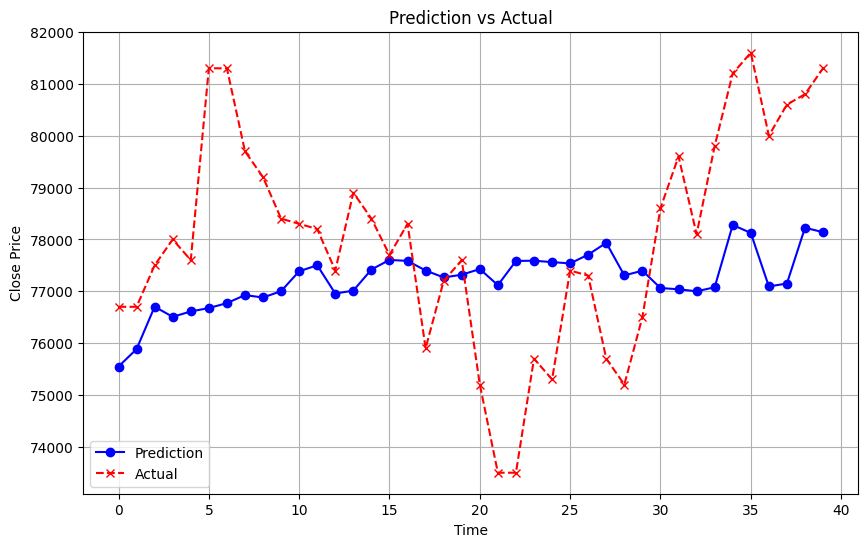

Root Mean Squared Error (RMSE): 2239.7841446806606


In [9]:
import matplotlib.pyplot as plt

# 예측 결과를 numpy 배열로 변환
final_predict = final_predict.T
expect_vals = final_predict[5]
prediction_numpy = expect_vals

# for_score['Close']의 마지막 10일치 데이터
for_score_close = vaild['Close']
for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]

# 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프의 크기 설정

# 예측 결과 그리기
plt.plot(prediction_numpy, marker='o', linestyle='-', color='b', label='Prediction')

# 실제 종가 데이터 그리기
plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')

# 그래프 제목, 축 이름, 범례 설정
plt.title('Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

# 그리드 표시
plt.grid(True)

# 그래프 표시
plt.show()

res_df =for_score_close_last_10.values.tolist()
squared_differences = []
for i in range(40):
    difference = expect_vals[i] - res_df[i]
    squared_difference = difference ** 2
    squared_differences.append(squared_difference)
# 텐서를 numpy 배열로 변환하여 MSE 계산
squared_differences = torch.tensor(squared_differences)
mse = squared_differences.mean().detach().numpy()
# RMSE 계산
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2045.9381332448222(60)
Root Mean Squared Error (RMSE): 2090.9379562601375(90)
Root Mean Squared Error (RMSE): 2183.346320000073(120)
Root Mean Squared Error (RMSE): 2100.6923194655865(150)
Root Mean Squared Error (RMSE): 2129.3726914814583(180)
Root Mean Squared Error (RMSE): 2136.8150915980427(240)

- id = false 
Root Mean Squared Error (RMSE): 2229.459148662886(60)
Root Mean Squared Error (RMSE): 2270.7872634761666(90)